# Electrochemistry analysis notebook (EIS · DPV · CV)

This notebook helps you **download** electrochemistry data (optionally from NOMAD) and **plot**:

- **EIS** (Nyquist & Bode plots, optional simple fitting)
- **DPV** (current vs potential)
- **CV** (current vs potential, multiple cycles)

## How to use this notebook (beginner-friendly)

1. Work **top → bottom** and run cells in order (`Shift + Enter`).
2. Cells marked **✅ Edit me** are the ones you typically change (sample IDs, file paths, plot options).
3. If a cell errors, read the message and **do not panic**:
   - Often it’s a missing package (`pip install ...`) or a missing file/token.
   - Re-run the cell after fixing the issue.


## Table of contents
1. Setup (install + imports)
2. Configure plotting style
3. Data input
   - A. NOMAD download (token + sample IDs)
   - B. Local files (CSV/TSV)
4. Plotting
   - EIS
   - DPV
   - CV
5. Troubleshooting


## 1) Setup

Run the next cell once per environment.

- If you use **JupyterLab** / **VS Code**: `matplotlib widget` gives interactive zoom/pan.
- If you get an error about `ipympl`, either install it (`pip install ipympl`) or switch to `%matplotlib inline`.


In [9]:
# If you run this on a managed environment that blocks installs, comment these lines.
# You can always install later when an import fails.
# !pip -q install numpy pandas matplotlib requests impedance ipympl
import sys
sys.path.append("../Electrochemical_analysis")   # Add the Electrochemical folder analysis into your path. Important to import the functions <- 
from Manuel_echem_function import *

from nomad_api_calls import *
import os
import io
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests

# Interactive plotting (optional)
try:
    get_ipython().run_line_magic("matplotlib", "widget")
except Exception:
    # Fallback if ipympl/widgets aren't available
    get_ipython().run_line_magic("matplotlib", "inline")

# Optional EIS fitting (only needed if you fit impedance spectra)
try:
    from impedance import preprocessing as imp_pre
    from impedance.models.circuits import CustomCircuit
    IMPEDANCE_AVAILABLE = True
except Exception:
    IMPEDANCE_AVAILABLE = False

print("Setup complete. impedance package available:", IMPEDANCE_AVAILABLE)


Setup complete. impedance package available: True


## 2) Plot style

You can tweak fonts/sizes here if you want prettier figures for presentations.

In [10]:

## Plotting preferences 

color_cm = ["#004f84ff", "#6cabe9ff", "#d15e57ff", "#ff7f2aff","#808080ff","#8787deff"]
# Expanded with 5 additional colors that harmonize with the original palette
color_cm = color_cm + ["#00a591ff", "#b2df8aff", "#f9c74fff", "#178eaeff", "#a70d88ff", "#373438ff",]

matplotlib.rc('font', size= 14) # controls default text sizes
matplotlib.rc('axes', titlesize=14) # fontsize of the axes title
matplotlib.rc('axes', labelsize=14) # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14) # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14) # fontsize of the tick labels
matplotlib.rc('legend', fontsize= 10) # legend fontsize
matplotlib.rc('figure', titlesize=14) # fontsize of the figure title


## 3) Data input

1) Login to Nomad

In [11]:
url = "https://nomad-hzb-se.de/nomad-oasis/api/v1"
token = os.environ['NOMAD_CLIENT_ACCESS_TOKEN'] 
if len(token) > 10:
    print("Token Recieved")

Token Recieved


#### Define the samples you want to download

✅ Edit me: Put your sample IDs into `file_id` (grouped the way you prefer for plotting).

This notebook originally grouped samples by concentration. You can use **any** grouping you like, e.g.
- different electrodes
- different electrolytes
- different annealing temperatures

If you don’t care about grouping, just use a single list inside `file_id`.


In [12]:
# Format batch ID per subbatch 
file_id=[["HZB_Echem_162_5_C-35","HZB_Echem_162_5_C-34"], #2
         ["HZB_Echem_162_4_C-27","HZB_Echem_162_4_C-28"], #1 
         ["HZB_Echem_162_3_C-21","HZB_Echem_162_3_C-20"], #0.5
         ["HZB_Echem_162_2_C-14","HZB_Echem_162_2_C-13"], #0.25
         ["HZB_Echem_162_1_C-6","HZB_Echem_162_1_C-7"],   #0.125
         ["HZB_Echem_161_9_C-21",  "HZB_Echem_161_9_C-23"]] #0

file_id.reverse()

# This concentration is manual for now, there are some corrections needed in the metadata (I am working on it) 
concentration = np.array([
    2.0,         # HZB_Echem_162_5
    1.0,         # HZB_Echem_162_4
    0.5,         # HZB_Echem_162_3
    0.25,        # HZB_Echem_162_2
    0.125,       # HZB_Echem_162_1
    0.0          # HZB_Echem_161_9 + 162_6
])
concentration = concentration[::-1]

#### Download data from NOMAD

flat_file_id = [item for sublist in file_id for item in sublist]

dataEIS=get_specific_data_of_samples_all(url, token, flat_file_id, "HySprint_ElectrochemicalImpedanceSpectroscopy")   # This function use the sample IDs to search for the NOMAD for impedance data
dataDPV=get_specific_data_of_samples_all(url, token, flat_file_id, "HySprint_DifferentialPulseVoltammetry")           # This function use the sample IDs to search for the NOMAD for DPV data
dataCV=get_specific_data_of_samples_all(url, token, flat_file_id, "HySprint_CyclicVoltammetry")                       # This function use the sample IDs to search for the NOMAD for Cyclic voltammetry


## 4) Plotting

Below are small plotting helpers. The goal is that you can:
- point them at **local DataFrames**, or
- adapt the NOMAD extraction functions to convert NOMAD archive data → DataFrames.

If you get stuck with column names, print `df.columns` and we’ll map them.


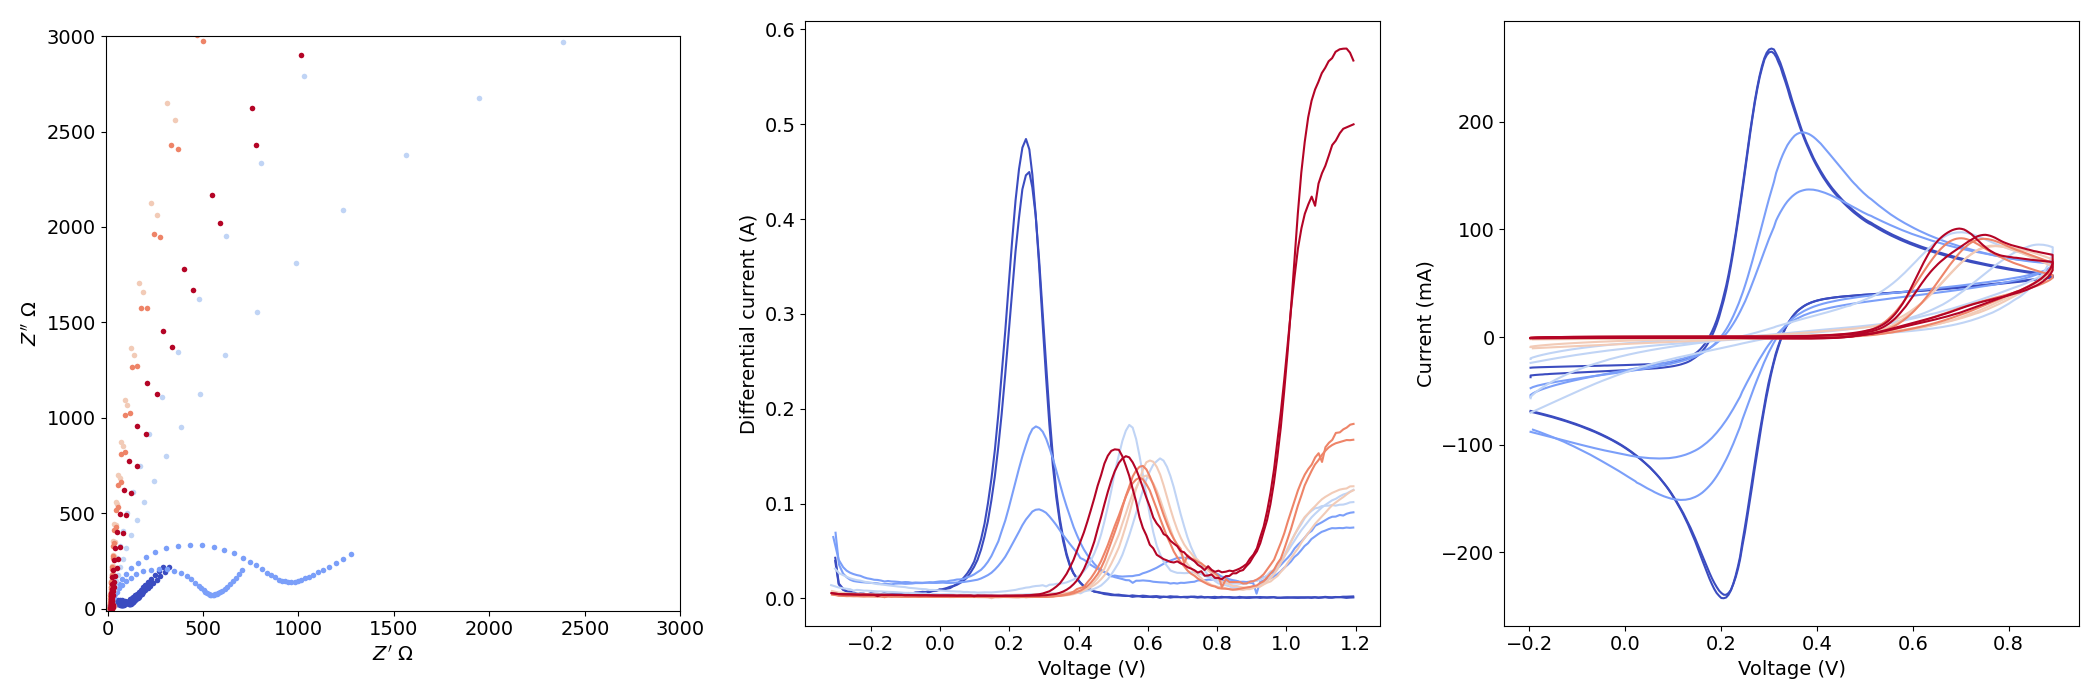

In [13]:
plt.close("all")

# Get the cividis colormap
cmap = plt.get_cmap("coolwarm")
# Create an array of 10 colors
colors = cmap(np.linspace(0, 1, len(concentration)))


fig,axis=plt.subplots(1,3,figsize=(7*3, 7) )

## This is important for the cylic voltammetry analysis 
reference_values=[0.05,0.1,0.2,0.3,0.5]  # Set of scan speed
threshold=0.02                           # Threshold for the detection of jumps. Used in CV_analysis_NOMAD 
scan_speed=0.05                          # Set the scan speed 
cycle_number=1                           # Number of cycle to plot 

label_experiment=[]
for jj,subbatch in enumerate(file_id):
    
    color=colors[jj]
    for ii,file in enumerate(subbatch):
         
        if ii==0:            
            #Get Concentration and SAM information from NOMAD
            #A=get_sample_description(url, token, [file])
            label=f"{concentration[jj]:.2f} mg/mL"
            label_experiment.append(f"{concentration[jj]:.2f} mg/mL")
        else: 
            label=None

        
        ## EIS plot
        axs=axis[0]
        for idx, entry in enumerate(dataEIS):
            if file == entry["samples"][0]["lab_id"]:
                # Download data from dataEIS[idx]
                axs.plot(entry["z_real"],entry["z_imaginary"],"o",color=color,
                         label=label,alpha=1,markersize=4, markeredgecolor='none')
        
                axs.set_aspect('equal')
                axs.set_xlabel(r"$Z'$ $\Omega$")
                axs.set_ylabel(r"$Z''$ $\Omega$")
                axs.set_xlim([-10,3000])
                axs.set_ylim([-10,3000])   
                #axs.legend()
                break
                
        ## DPV plot
        axs=axis[1]
        for idx, entry in enumerate(dataDPV):
            if file == entry["samples"][0]["lab_id"]:
                # Download data from dataEIS[idx]
                axs.plot(entry["voltage"],entry["current"],color=color,label=label,alpha=1)   # From NOMAD current is equal to the differential current
                axs.set_xlabel(r"Voltage (V)")
                axs.set_ylabel(r"Differential current (A)")  
                #axs.legend()        
                break
                
        ## CV plot
        axs=axis[2]
        for idx, entry in enumerate(dataCV):
            if file == entry["samples"][0]["lab_id"]:
                # Download data from dataEIS[idx]
                CV_df=CV_analysis_NOMAD(entry["cycles"][0]["time"],entry["cycles"][0]["voltage"],entry["cycles"][0]["current"],reference_values,threshold,plot_SS=False) #Function to assign scan speed
                
                df1 = CV_df[CV_df['Speed_bin'] == "0.05"]          #Filter by scan speed
                df1=assign_cycles_NOMAD(df1)                       #Separate the cycle number  
                df_cycle2 = df1[df1["Cycle"] == cycle_number]      #Filter data by cycle number
                
                axs.plot(df_cycle2["voltage"], df_cycle2["current"]*1e3,color=color, label=label,alpha=1)  # Plot
                axs.set_xlabel(r"Voltage (V)")
                axs.set_ylabel(r"Current (mA)")  
                #axs.legend()      
                break

# #plt.savefig("Overall_plot_Echem.png",dpi=500)
plt.tight_layout()
plt.savefig("Overall_plot_Echem.svg")

plt.show()
